In [1]:
%load_ext autoreload
%autoreload 2

## Noise Filtering: 

ECG data is often contaminated with noise such as power line interference, baseline wander, and electromyographic noise. A common approach is to use a bandpass filter.

#### Why Apply a Bandpass Filter?

When dealing with ECG (Electrocardiogram) data, it is essential to filter out unwanted noise and interferences that can distort the signal. ECG signals are often contaminated with noise such as:

- **High-frequency noise**, like electromyographic (EMG) noise from muscle contractions.
- **Low-frequency noise**, like baseline wander due to respiration or patient movement.
  
A bandpass filter allows us to retain the frequency components that are typical for the ECG signal (usually in the range of 0.5 Hz to 40 Hz) while filtering out the noise outside this range.

### How Does Bandpass Filtering Work?

A bandpass filter permits frequencies within a certain range and attenuates frequencies outside that range. In the context of ECG signals:

- A **low cut-off frequency** (around 0.5 Hz) is set to eliminate low-frequency noise such as baseline wander.
- A **high cut-off frequency** (around 40 Hz) is set to remove high-frequency noise such as EMG interference.

### Implementation in Python

We implement the bandpass filter using the `scipy.signal` library. The filter can be applied in two ways:

1. **Zero-Phase Filtering**: Using `sosfiltfilt` for bidirectional filtering, which doesn't introduce any phase shift in the signal.
2. **Forward Filtering**: Using `lfilter`, which applies the filter in a forward direction only.

- **`sosfiltfilt`**: Chosen as the primary method due to its zero-phase characteristic, ensuring no phase distortion in ECG signals, which is crucial for accurate waveform analysis.
- **`lfilter` Option**: Included to offer flexibility for scenarios where real-time processing or computational efficiency takes precedence over phase accuracy. This makes the approach adaptable to a wider range of applications.

In [12]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, lfilter


def bandpass_filter(signal, fs, filter_order=6, low_cut=0.5, high_cut=40, zero_phase=True):
    """
    Apply a bandpass filter to an ECG signal with an option to choose zero-phase filtering.

    Parameters:
    - signal (numpy array): The ECG signal.
    - fs (float): Sampling frequency of the ECG signal.
    - filter_order (int): Order of the filter.
    - low_cut (float): Low cutoff frequency for the high-pass filter.
    - high_cut (float): High cutoff frequency for the low-pass filter.
    - zero_phase (bool): If True, use zero-phase filtering (sosfiltfilt). If False, use forward filtering (lfilter).

    Returns:
    - numpy array: Filtered ECG signal.
    """
    
    if fs <= high_cut * 2:
        raise ValueError("Sampling frequency is too low for the selected high cutoff frequency.")

    nyquist_freq = 0.5 * fs
    low = low_cut / nyquist_freq
    high = high_cut / nyquist_freq
    
    # Design the filter
    if zero_phase:
        sos = butter(filter_order, [low, high], btype='band', output='sos', analog=False)
    else:
        b, a = butter(filter_order, [low, high], btype='band', analog=False)
        
    # Apply the filter
    if len(np.shape(signal)) == 2:
        # Multi-channel ECG signal
        [num_samples, num_channels] = np.shape(signal)
        fsig = np.zeros([num_samples, num_channels])
        for i in range(num_channels):
            if zero_phase:
                fsig[:, i] = sosfiltfilt(sos, signal[:, i])
            else:
                fsig[:, i] = lfilter(b, a, signal[:, i])
    elif len(np.shape(signal)) == 1:
        # Single-channel ECG signal
        if zero_phase:
            fsig = sosfiltfilt(sos, signal)
        else:
            fsig = lfilter(b, a, signal)
        
    return fsig


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class BandpassFilter(BaseEstimator, TransformerMixin):
    def __init__(self, fs, filter_order=6, low_cut=0.5, high_cut=40, zero_phase=True):
        self.fs = fs
        self.filter_order = filter_order
        self.low_cut = low_cut
        self.high_cut = high_cut
        self.zero_phase = zero_phase
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return bandpass_filter(X, self.fs, self.filter_order, self.low_cut, self.high_cut, self.zero_phase)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [14]:
from src.data.load_data import load_dataset, load_ecg, parse_header
from src.ecg.viz import plot_ecg
from src.config import TRAINING_DIR

dataset = load_dataset(TRAINING_DIR)

  0%|          | 0/8528 [00:00<?, ?it/s]

100%|██████████| 8528/8528 [00:00<00:00, 466781.83it/s]


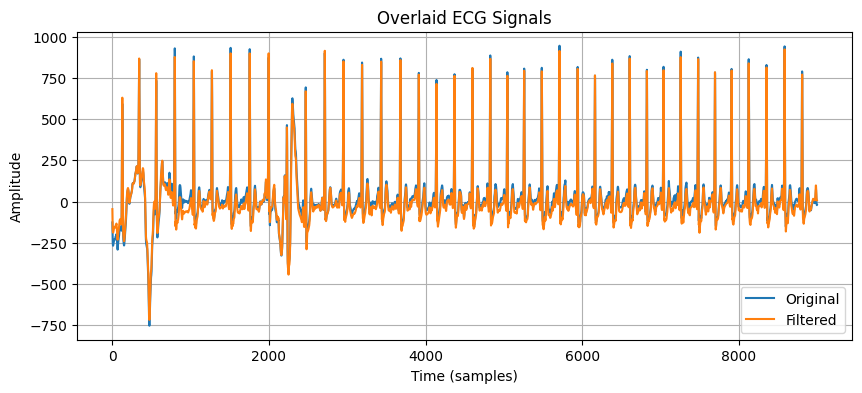

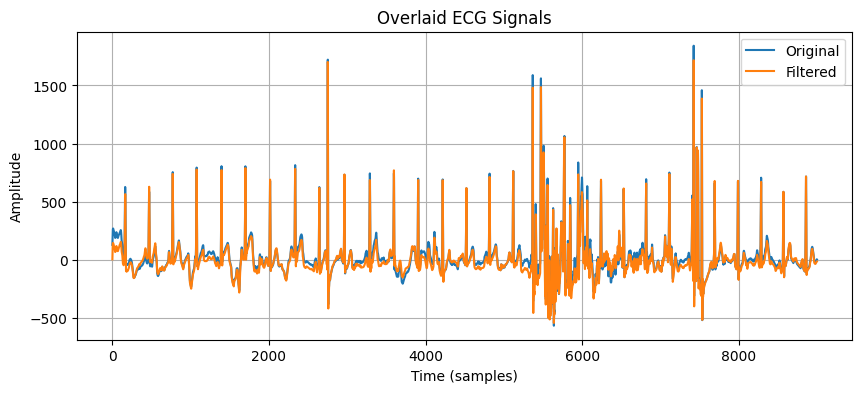

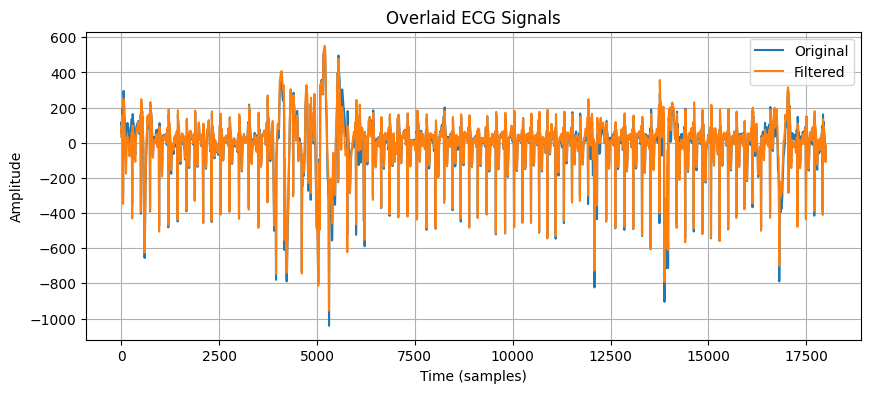

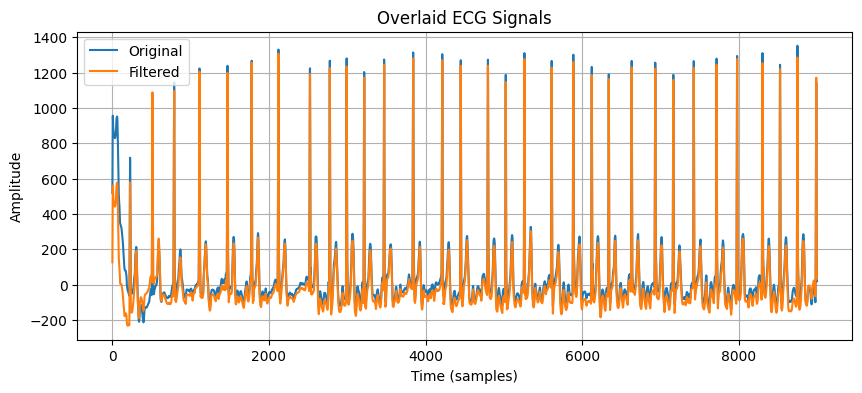

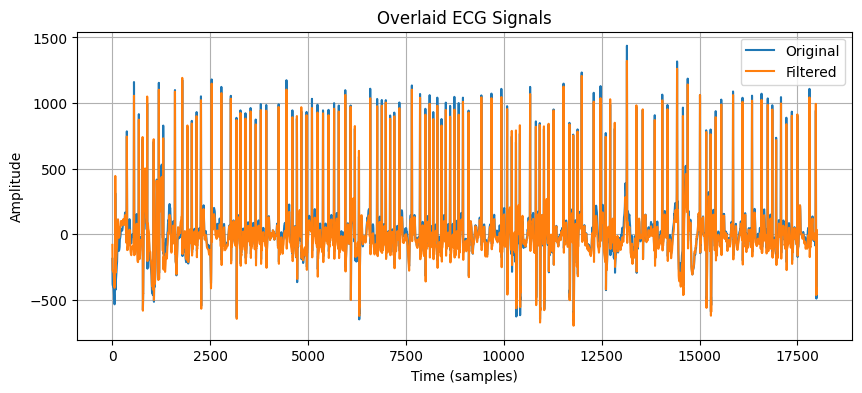

In [18]:
from sklearn.pipeline import Pipeline

for data_dict in dataset[:5]:
    ecg = load_ecg(data_dict['ecg_file'])
    header = parse_header(data_dict['hea_file'])
    fs = header['sample_rate']
    
    pipeline = Pipeline([
        ('bandpass_filter', BandpassFilter(fs))
    ])
    
    filtered_ecg = pipeline.fit_transform(ecg)    
   
    plot_ecg([ecg, filtered_ecg], overlaid=True, title='ECG Signal', labels=['Original', 'Filtered'])

## Normalization of ECG Signals

### Purpose of Normalization

Normalization is a preprocessing step where the amplitude of the ECG signals is scaled to a standard range. This is important in datasets like the PhysioNet/Computing in Cardiology Challenge 2017, where ECG recordings might come from various devices with different amplitude scales. Normalization ensures consistency across all signals, which is essential for comparative analysis and machine learning models.


### Method of Normalization

In this project, we will employ Min-Max normalization to scale the ECG signal amplitudes. This method transforms the data to have a minimum value of 0 and a maximum value of 1. The formula used is:

$$ \text{Normalized Signal} = \frac{\text{Signal} - \text{Min(Signal)}}{\text{Max(Signal)} - \text{Min(Signal)}} $$


This approach is chosen because it preserves the shape of the ECG waveform while standardizing its amplitude.

In [11]:
import numpy as np

def normalize_ecg(signal):
    """
    Normalize an ECG signal using Min-Max normalization.

    Parameters:
    - signal (numpy array): The ECG signal.

    Returns:
    - numpy array: Normalized ECG signal.
    """
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal


In [19]:
# convert to a transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NormalizeECG(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return normalize_ecg(X)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

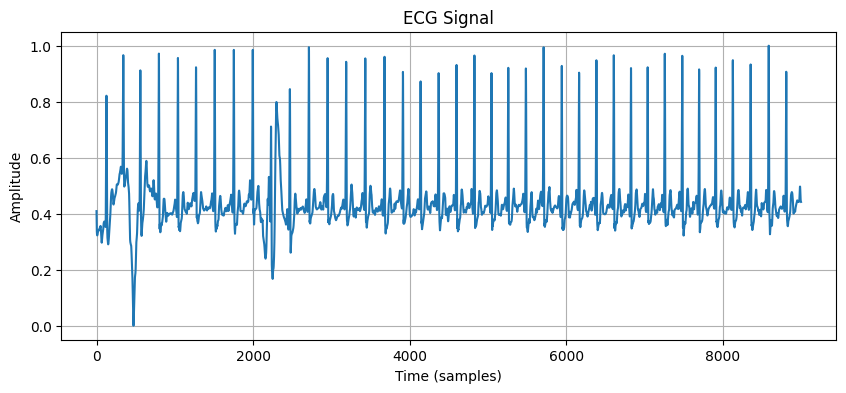

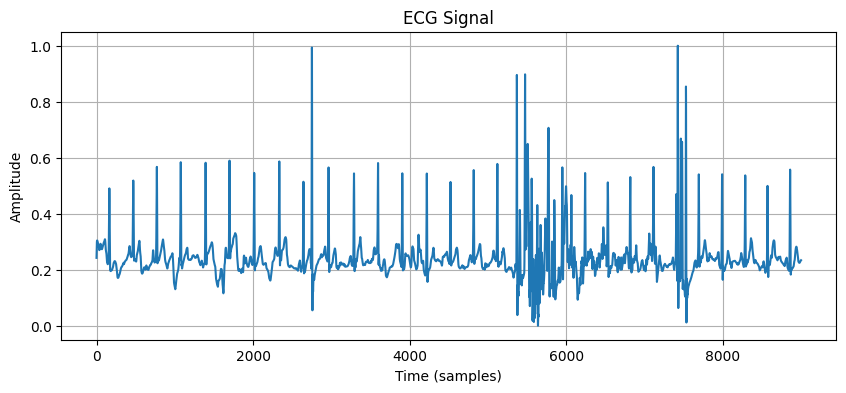

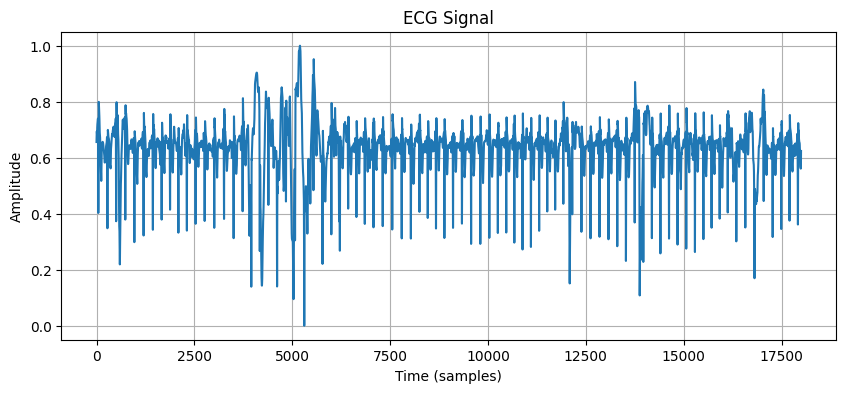

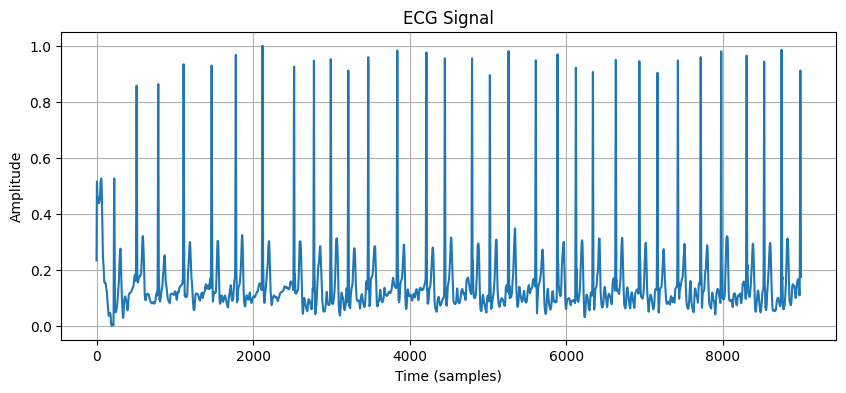

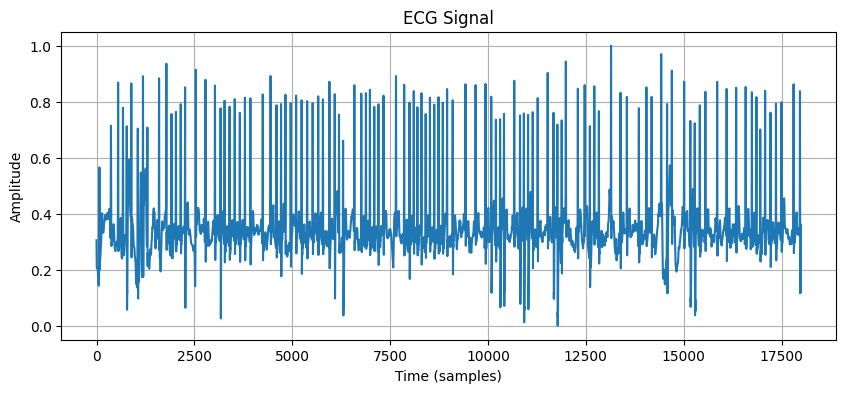

In [21]:
# let's add a normalization step to our pipeline
for data_dict in dataset[:5]:
    ecg = load_ecg(data_dict['ecg_file'])
    header = parse_header(data_dict['hea_file'])
    fs = header['sample_rate']
    
    pipeline = Pipeline([
        ('bandpass_filter', BandpassFilter(fs)),
        ('normalize_ecg', NormalizeECG())
    ])
    
    preprocessed_ecg = pipeline.fit_transform(ecg)
    
    plot_ecg(preprocessed_ecg)

## Handling Missing Data

In single-lead ECG data, missing data would typically manifest as gaps in the continuous recording.

Given that the dataset is expected to be of high quality, the primary check for missing data will involve ensuring there are no unexpected gaps in the recordings. This check is a precautionary step to confirm the dataset's completeness.

In [23]:
def check_for_gaps(ecg_file_path):
    """
    Check for gaps in a single-lead ECG signal.

    Parameters:
    - ecg_file_path (str): File path to the ECG signal.

    Returns:
    - bool: True if gaps are detected, False otherwise.
    """
    signal = load_ecg(ecg_file_path)
    if np.any(np.isnan(signal)):
        return True
    return False

In [24]:
any([check_for_gaps(data_dict['ecg_file']) for data_dict in dataset])

False

All files have no gaps

## Segmentation

Segmentation in ECG signal processing involves dividing the continuous ECG recording into smaller, manageable segments or beats. This is a critical step for a few reasons:


1. **Focus on Relevant Features**: Segmentation allows for the analysis of specific parts of the ECG cycle, such as the P wave, QRS complex, and T wave, which are crucial for identifying arrhythmias like atrial fibrillation (AF).
2. **Data Manageability**: It makes the data more manageable and ensures that the machine learning models receive uniformly sized input.
3. **Improved Model Performance**: By feeding the model with specific segments, it can learn the intricate patterns associated with different cardiac conditions more effectively.

As the project aims to detect atrial fibrillation, a condition often identified by irregularities in the QRS complex and the rhythm of the heartbeats. Effective segmentation allows for a more focused analysis of these features, thereby improving the accuracy of AF detection.

In [25]:
import numpy as np

def segment_ecg(signal, window_size, overlap_size):
    """
    Segment an ECG signal into fixed-size windows.

    Parameters:
    - signal (numpy array): The ECG signal.
    - window_size (int): The size of each window in samples.
    - overlap_size (int): The size of overlap between consecutive windows in samples.

    Returns:
    - list of numpy arrays: List of segmented ECG windows.
    """
    segments = []
    start = 0
    end = window_size
    while end <= len(signal):
        segment = signal[start:end]
        segments.append(segment)
        start += window_size - overlap_size
        end = start + window_size
    return segments

In [26]:
# convert to a transformer

from sklearn.base import BaseEstimator, TransformerMixin

class SegmentECG(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, overlap_size):
        self.window_size = window_size
        self.overlap_size = overlap_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return segment_ecg(X, self.window_size, self.overlap_size)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

In [35]:
# let's add a segmentation step to our pipeline
from tqdm import tqdm

for data_dict in tqdm(dataset, total=len(dataset), desc='Preprocessing ECG signals'):
    ecg = load_ecg(data_dict['ecg_file'])
    header = parse_header(data_dict['hea_file'])
    fs = header['sample_rate']
    
    pipeline = Pipeline([
        ('bandpass_filter', BandpassFilter(fs)),
        ('normalize_ecg', NormalizeECG()),
        ('segment_ecg', SegmentECG(window_size=2000, overlap_size=1000))
    ])
    
    segmented_ecg = pipeline.fit_transform(ecg)
    
    data_dict['segmented_ecg'] = segmented_ecg        

Preprocessing ECG signals:   0%|          | 0/8528 [00:00<?, ?it/s]

Preprocessing ECG signals: 100%|██████████| 8528/8528 [00:11<00:00, 753.93it/s]


In [ ]:
import numpy as np

from scipy.signal import butter, sosfiltfilt, lfilter

from sklearn.base import BaseEstimator, TransformerMixin

class BandpassFilter(BaseEstimator, TransformerMixin):
    def __init__(self, fs, filter_order=6, low_cut=0.5, high_cut=40, zero_phase=True):
        self.fs = fs
        self.filter_order = filter_order
        self.low_cut = low_cut
        self.high_cut = high_cut
        self.zero_phase = zero_phase
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return BandpassFilter.bandpass_filter(X, self.fs, self.filter_order, self.low_cut, self.high_cut, self.zero_phase)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    @staticmethod
    def bandpass_filter(signal, fs, filter_order=6, low_cut=0.5, high_cut=40, zero_phase=True):
        """
        Apply a bandpass filter to an ECG signal with an option to choose zero-phase filtering.

        Parameters:
        - signal (numpy array): The ECG signal.
        - fs (float): Sampling frequency of the ECG signal.
        - filter_order (int): Order of the filter.
        - low_cut (float): Low cutoff frequency for the high-pass filter.
        - high_cut (float): High cutoff frequency for the low-pass filter.
        - zero_phase (bool): If True, use zero-phase filtering (sosfiltfilt). If False, use forward filtering (lfilter).

        Returns:
        - numpy array: Filtered ECG signal.
        """
        
        if fs <= high_cut * 2:
            raise ValueError("Sampling frequency is too low for the selected high cutoff frequency.")

        nyquist_freq = 0.5 * fs
        low = low_cut / nyquist_freq
        high = high_cut / nyquist_freq
        
        # Design the filter
        if zero_phase:
            sos = butter(filter_order, [low, high], btype='band', output='sos', analog=False)
        else:
            b, a = butter(filter_order, [low, high], btype='band', analog=False)
            
        # Apply the filter
        if len(np.shape(signal)) == 2:
            # Multi-channel ECG signal
            [num_samples, num_channels] = np.shape(signal)
            fsig = np.zeros([num_samples, num_channels])
            for i in range(num_channels):
                if zero_phase:
                    fsig[:, i] = sosfiltfilt(sos, signal[:, i])
                else:
                    fsig[:, i] = lfilter(b, a, signal[:, i])
        elif len(np.shape(signal)) == 1:
            # Single-channel ECG signal
            if zero_phase:
                fsig = sosfiltfilt(sos, signal)
            else:
                fsig = lfilter(b, a, signal)
            
        return fsig


class NormalizeECG(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return NormalizeECG.normalize_ecg(X)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    @staticmethod
    def normalize_ecg(signal):
        """
        Normalize an ECG signal using Min-Max normalization.

        Parameters:
        - signal (numpy array): The ECG signal.

        Returns:
        - numpy array: Normalized ECG signal.
        """
        min_val = np.min(signal)
        max_val = np.max(signal)
        normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal
    
    
class SegmentECG(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, overlap_size):
        self.window_size = window_size
        self.overlap_size = overlap_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return SegmentECG.segment_ecg(X, self.window_size, self.overlap_size)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    @staticmethod
    def segment_ecg(signal, window_size, overlap_size):
        """
        Segment an ECG signal into fixed-size windows.

        Parameters:
        - signal (numpy array): The ECG signal.
        - window_size (int): The size of each window in samples.
        - overlap_size (int): The size of overlap between consecutive windows in samples.

        Returns:
        - list of numpy arrays: List of segmented ECG windows.
        """
        segments = []
        start = 0
        end = window_size
        while end <= len(signal):
            segment = signal[start:end]
            segments.append(segment)
            start += window_size - overlap_size
            end = start + window_size
        return segments


class ECGPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, window_size, overlap_size):
        self.window_size = window_size
        self.overlap_size = overlap_size

    def fit(self, X, y=None):
        # Fit method is required to be compatible with sklearn's Pipeline
        # In this case, our transformer does not need to learn from data, so we just return self
        return self

    def transform(self, dataset):
        # Transform method applies the preprocessing steps
        processed_data = []

        for data_dict in dataset:
            ecg = self.load_ecg(data_dict['ecg_file'])
            header = self.parse_header(data_dict['hea_file'])
            fs = header['sample_rate']

            pipeline = Pipeline([
                ('bandpass_filter', BandpassFilter(fs)),
                ('normalize_ecg', NormalizeECG()),
                ('segment_ecg', SegmentECG(window_size=self.window_size, overlap_size=self.overlap_size))
            ])

            segmented_ecg = pipeline.fit_transform(ecg)
            data_dict['segmented_ecg'] = segmented_ecg
            processed_data.append(data_dict)

        return processed_data


